In [1]:
from petls import Complex

In [ ]:
# This cell is copied from pyDowker
# by Niklas Hellmer and Jan Spalinski, but only the portion
# that's necessary for petls to make a "Persistent Dowker Laplacian"
# See https://github.com/nihell/pyDowker

# MIT License

# Copyright (c) 2024 Niklas Hellmer

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

from gudhi import SimplexTree
import numpy as np

class DowkerComplex:
    """
    Class MNeighborComplex. Constructs Dowker's simplicial complex for a relation.
    Filtrations can be added using filtered relations, or total weight, or combining both into a bifiltration.
    """

    def __init__(self, rel_matrix, max_filtration=float('inf')) -> None:
        """_summary_
        Constructor for the filtered Dowker complex from the relations given by sublevels of the matrix rel_matrix.
        The vertices in the complex will correspond to the rows of the matrix.
        
        Parameters
        ----------
        rel_matrix (Sequence[Sequence[float]]): distance matrix (full square or lower triangular).
        max_filtration (float): specifies the maximal filtration value to be considered.      
        """
        self.rel_matrix = rel_matrix
        self.st = None
        
        
     

    def create_simplex_tree(self, 
                            max_dimension, 
                            filtration = 'None', 
                            m=1, 
                            level = 0, 
                            max_filtration = np.inf):
        """
            Creates a gudhi simplex tree storing a skeleton of the (filtered) simpicial complex.
            Uses recursive algorithm with nummpy arrays, fast for small datasets but worse runtime and memory complexity.


        Parameters
        ----------
        max_dimension : int
            Dimension of the skeleton to compute.
        filtration : str, optional
            valid values: "Sublevel", "TotalWeight", "None".
            "Sublevel" takes the filtration of relations by sublevels of the matrix.
            "Total weight" takes the filtration by sublevels of the negative total weight function.
            By default 'None'
        m : int, optional
            restriction to this superlevel of total weight (this is only used if filtration!="TotalWeight"); m=1 corresponds to the whole Dowker complex, by default 1
        level : int, optional
            restriction to this sublevel of the matrix as relation (this is only used if filtration!="Sublevel"), by default 0
        max_filtration : float, optional
            cutoff for the filtration (only used if filtration="Sublevel"), by default np.inf

        Returns
        -------
        gudhi.SimplexTree
            The simplex tree storing the (filtered) simplicial complex
        """
        
        self.st=SimplexTree()


        LAMBDA = self.rel_matrix
        num_points=len(LAMBDA)
        
        if filtration == "Sublevel":
            if LAMBDA.dtype != np.float64:
                raise TypeError("Only float arrays are allowed with sublevel filtration") 
            def append_upper_cofaces(sigma, r, witness_values):
                if r > max_filtration:
                    return
                self.st.insert(sigma,r)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]

                        j_witness_values=LAMBDA[j,:]
                        common_witness_values = np.maximum(j_witness_values,witness_values)
                        new_r = np.partition(common_witness_values, m-1)[m-1]
                        append_upper_cofaces(tau, new_r, common_witness_values)

            for k in range(num_points-1,-1,-1):
                witness_values = LAMBDA[k,:]
                r_new = np.partition(witness_values, m-1)[m-1]
                append_upper_cofaces([k],r_new,witness_values)
            return self.st
        
        elif filtration == "TotalWeight":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                
                self.st.insert(sigma,-np.sum(witnesses))
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if np.sum(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st

        elif filtration == "None":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                if len(witnesses)<m:
                    return
                self.st.insert(sigma)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if len(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st
        
        else:
            raise Exception("filtration parameter must be one of 'Sublevel', 'TotalWeight', 'None'")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
# import networkx as nx

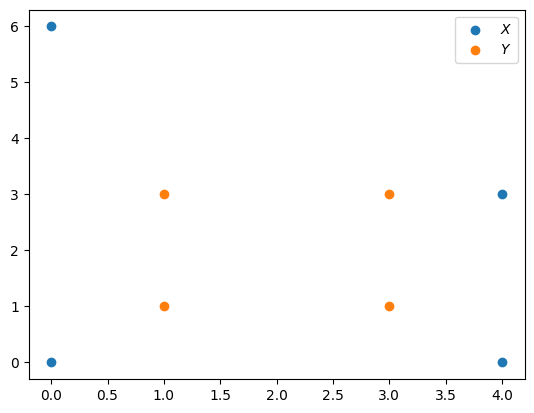

In [5]:
# Let us consider two small point clouds containing four points each.
X = np.array([(0,0),(4,0), (0,6),(4,3)])
Y = np.array([(1,3),(3,3), (3,1),(1,1)])
f,ax = plt.subplots()
ax.scatter(X[:,0],X[:,1], label='$X$')
ax.scatter(Y[:,0],Y[:,1], label='$Y$')
ax.legend()
plt.show()

# For every combination of the two point clouds, we can consider the corresponding Dowker complex.

Dow_XX = DowkerComplex(pairwise_distances(X,X)).create_simplex_tree(max_dimension=4, filtration = "Sublevel",m=1)
Dow_XY = DowkerComplex(pairwise_distances(X,Y)).create_simplex_tree(max_dimension=4, filtration = "Sublevel",m=1)
Dow_YX = DowkerComplex(pairwise_distances(Y,X)).create_simplex_tree(max_dimension=4, filtration = "Sublevel",m=1)
Dow_YY = DowkerComplex(pairwise_distances(Y,Y)).create_simplex_tree(max_dimension=4, filtration = "Sublevel",m=1)



In [6]:
PL_XY = Complex(simplex_tree=Dow_XY)
PL_YX = Complex(simplex_tree=Dow_YX)

In [8]:
spectra_XY = PL_XY.spectra(allpairs=True)
spectra_YX = PL_YX.spectra()
print("XY", spectra_XY)
print("YX", spectra_YX)
set_differences = set(spectra_XY).symmetric_difference(set(spectra_YX))
print("Set differences:", set_differences)

TypeError: 'NoneType' object is not iterable

In [13]:
print("XY")
print(pairwise_distances(X,Y))
print("YX")
print(pairwise_distances(Y,X))

XY
[[3.16227766 4.24264069 3.16227766 1.41421356]
 [4.24264069 3.16227766 1.41421356 3.16227766]
 [3.16227766 4.24264069 5.83095189 5.09901951]
 [3.         1.         2.23606798 3.60555128]]
YX
[[3.16227766 4.24264069 3.16227766 3.        ]
 [4.24264069 3.16227766 4.24264069 1.        ]
 [3.16227766 1.41421356 5.83095189 2.23606798]
 [1.41421356 3.16227766 5.09901951 3.60555128]]
